# Beer Recommender System
Sam ONeill <br />
Aaron Plesset <br />
Xiaoxiong Xu <br />
Xiaoyue Zhu

1. **Summary of the project**: The goal of our project is to custmize our own API extracting data from [BeerAdvocate](https://www.beeradvocate.com), and use that data to recommend ten beers for each user who has not tried them yet. We use Collaborative Filtering algrithms to learn each similar users' rating pattern, similar beers, or we predict beers that users may like through Machine Learning.
<br><br>
2. **Summary of the data**: Generally, we have two different dataframes. The first data consists of 600 beers rated by 159 users. Scores are scaled froms 1.0 to 5.0, and 0.0 are missing values, which are cosidered that users have not try yet. Another dataset has basic information of 1238 different beers the infomation attributes are as follow:
```
brewery: name of brewery
state: name of producing state
country: name of producing country
website: website of brewery
style: style of beers
abv: aka alcohol by volume
availiability: released period
description: description of beers
ranking: ranking
num_reviews: number of users' reviews
num_ratings: number of users' rating
num_wants: number of users who want the beers
```

## i. Load Modules

In [1]:
import os
import math
import numpy as np
import pandas as pd
from math import sqrt
from scipy import interp
from itertools import cycle
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
import sklearn.decomposition as skld
from sklearn.metrics import roc_curve,auc
from scipy.spatial.distance import cosine
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error, pairwise_distances, mean_absolute_error

## ii. Load Data

In [2]:
# Get the path of data sets
new_rawData_path = os.path.abspath('test_ratings_df_6.1.18')
rawData_info_1_path = os.path.abspath('top_beer_df_6.2.18')
rawData_info_2_path = os.path.abspath('large_beer_df_6.2.18')

In [3]:
# Load data
new_rawData = pd.read_csv(new_rawData_path, index_col=0)
rawData_info_1 = pd.read_csv(rawData_info_1_path, index_col=0)
rawData_info_2 = pd.read_csv(rawData_info_2_path,index_col=0)

# 1. Exploring the Data and Visualization

## 1.1 Outlook of Data Structure

In [4]:
print(new_rawData.shape)
new_rawData.head()

(600, 159)


,Bugsmcl,Jimmeekrek,StonedTrippin,jsearley3364,Chadlossie,WOLFGANG,fossage78,Brent_B,FocalBanged,Aetherbulb,...,jplopez21,AussieActor,mayxday,Mojua,steve032,Seamus,grze,Davepoolesque,sourdog,fthegiants
Kentucky Brunch Brand Stout,5.00,4.81,4.55,4.91,5.00,5.00,5.0,4.92,5.00,5.00,...,5.0,4.94,5.00,5.00,5.00,5.00,4.99,0.0,4.75,0.0
IPA,0.00,3.75,3.56,0.00,0.00,3.50,3.5,4.25,0.00,0.00,...,4.0,0.00,4.25,0.00,0.00,0.00,0.00,0.0,4.25,0.0
Heady Topper,3.79,4.50,0.00,4.81,4.50,4.55,0.0,0.00,4.31,4.50,...,4.5,4.64,5.00,4.56,4.58,4.71,4.00,0.0,0.00,0.0
Imperial Stout,0.00,4.50,0.00,0.00,0.00,4.25,0.0,0.00,0.00,4.25,...,4.0,0.00,4.57,4.10,4.50,4.04,0.00,3.9,4.25,0.0
Bourbon County Brand Coffee Stout,4.54,4.73,0.00,4.65,4.25,0.00,4.5,0.00,4.48,0.00,...,0.0,4.93,4.91,4.56,4.68,4.84,4.75,0.0,0.00,0.0


In [5]:
print(rawData_info_1.shape)
rawData_info_1.head()

(250, 12)


,brewery,state,country,website,style,abv,availability,description,ranking,num_reviews,num_ratings,num_wants
Kentucky Brunch Brand Stout,Toppling Goliath Brewing Company,Iowa,United States,tgbrews.com,American Double Imperial Stout,12.00%,Rotating,This beer is the real McCoy. Barrel aged and c...,#1,132,688,3701
Heady Topper,The Alchemist Brewery and Visitors Center,Vermont,United States,alchemistbeer.com,American Double Imperial IPA,8.00%,Year-round,"""An American Double IPA"" 75 IBU 8.0% ABV. ""Dri...",#2,2458,14091,9437
Barrel-Aged Abraxas,Perennial Artisan Ales,Missouri,United States,perennialbeer.com,American Double Imperial Stout,11.00%,Rotating,Imperial Stout aged Twelve months in Rittenhou...,#3,142,1411,2537
Marshmallow Handjee,3 Floyds Brewing Co.,Indiana,United States,3floyds.com,Russian Imperial Stout,15.00%,Spring,Dark Lord Russian Imperial Stout aged in a var...,#4,317,1589,4493
Hunahpu's Imperial Stout - Double Barrel Aged,Cigar City Brewing,Florida,United States,cigarcitybrewing.com,American Double Imperial Stout,11.00%,Rotating,Stout aged on Peruvian cacao nibs ancho and pa...,#5,154,1561,1707


In [6]:
print(rawData_info_2.shape)
rawData_info_2.head()

(1028, 12)


,brewery,state,country,website,style,abv,availability,description,ranking,num_reviews,num_ratings,num_wants
Fat Tire Amber Ale,New Belgium Brewing,Colorado,United States,newbelgium.com,American Amber Red Ale,5.20%,Year-round,No notes at this time.,#40154,2080,8899,249
Nugget Nectar,Tröegs Brewing Company,Pennsylvania,United States,troegs.com,American Amber Red Ale,7.50%,Spring,Squeeze those hops for all they're worth! Nugg...,#453,2573,8657,1430
Hop Head Red Ale,Green Flash Brewing Co.,California,United States,greenflashbrew.com,American Amber Red Ale,8.10%,Year-round,In 2011 the recipe was altered to bump the IBU...,#5036,965,3422,178
Amber Ale,Bell's Brewery - Eccentric Café & General Store,Michigan,United States,bellsbeer.com,American Amber Red Ale,5.80%,Year-round,The beer that helped build our brewery; Bell’s...,#12956,993,3192,168
Hopback Amber Ale,Tröegs Brewing Company,Pennsylvania,United States,troegs.com,American Amber Red Ale,6.00%,Year-round,Standing 12 ft. tall at the center of the brew...,#5041,1176,3124,133


__Since we found two datasets have the same attributes with different beers, we merge two dataframes together:__

In [7]:
# Merge two datasets with beer information
overall_info = pd.concat([rawData_info_1,rawData_info_2], join='outer', ignore_index=False)
overall_info = overall_info[~overall_info.index.duplicated(keep='first')]
overall_info.shape

(1238, 12)

In [8]:
overall_info.head()

,brewery,state,country,website,style,abv,availability,description,ranking,num_reviews,num_ratings,num_wants
Kentucky Brunch Brand Stout,Toppling Goliath Brewing Company,Iowa,United States,tgbrews.com,American Double Imperial Stout,12.00%,Rotating,This beer is the real McCoy. Barrel aged and c...,#1,132,688,3701
Heady Topper,The Alchemist Brewery and Visitors Center,Vermont,United States,alchemistbeer.com,American Double Imperial IPA,8.00%,Year-round,"""An American Double IPA"" 75 IBU 8.0% ABV. ""Dri...",#2,2458,14091,9437
Barrel-Aged Abraxas,Perennial Artisan Ales,Missouri,United States,perennialbeer.com,American Double Imperial Stout,11.00%,Rotating,Imperial Stout aged Twelve months in Rittenhou...,#3,142,1411,2537
Marshmallow Handjee,3 Floyds Brewing Co.,Indiana,United States,3floyds.com,Russian Imperial Stout,15.00%,Spring,Dark Lord Russian Imperial Stout aged in a var...,#4,317,1589,4493
Hunahpu's Imperial Stout - Double Barrel Aged,Cigar City Brewing,Florida,United States,cigarcitybrewing.com,American Double Imperial Stout,11.00%,Rotating,Stout aged on Peruvian cacao nibs ancho and pa...,#5,154,1561,1707


In [9]:
# Beer info
set(overall_info.columns)

{'abv',
 'availability',
 'brewery',
 'country',
 'description',
 'num_ratings',
 'num_reviews',
 'num_wants',
 'ranking',
 'state',
 'style',
 'website'}

In [10]:
# Username info
new_rawData.columns

Index(['Bugsmcl', 'Jimmeekrek', 'StonedTrippin', 'jsearley3364', 'Chadlossie',
       'WOLFGANG', 'fossage78', 'Brent_B', 'FocalBanged', 'Aetherbulb',
       ...
       'jplopez21', 'AussieActor', 'mayxday', 'Mojua', 'steve032', 'Seamus',
       'grze', 'Davepoolesque', 'sourdog', 'fthegiants'],
      dtype='object', length=159)

__Checking the missing values:__

In [11]:
np.count_nonzero(new_rawData==0)

68269

In [12]:
new_rawData.shape

(600, 159)

__The missing values take a large portion of data. This will negatively effect the accuracy of our algorithms.__

## 1.2 Visualization

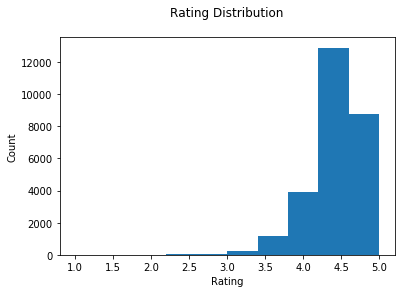

In [13]:
# Rating Distribution
rawData_cp = new_rawData.copy()
rawData_cp = np.array(rawData_cp)
rawData_cp = rawData_cp[rawData_cp != 0.0]
plt.hist(rawData_cp)
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.savefig('system1.png', bbox_inches='tight')
plt.show()

__The scores are distributed between 2.0 to 5.0, and most part of socres are between 4.0 to 5.0.__

In [14]:
# Removing 0.0 for histogram
def nonzerp_np(data):
    data_np = np.array(data)
    nonzero = data_np[data_np != 0]
    return(nonzero)

__Here, we randomly choose four beers and see their rating distribution. Accoring to the histogram on the top left, the most amount of the score is 5.0. Users seems like Kentucky Brunch brand Stout. The hsitogram on the top right shows that Hunahpu's Imperial Stout is also a prevalent beers. The scores of Marshmallow Handjee mainly distributed from 4.5 to 5.0. But Hopslam Ale seems do not have too much five-star rating.__

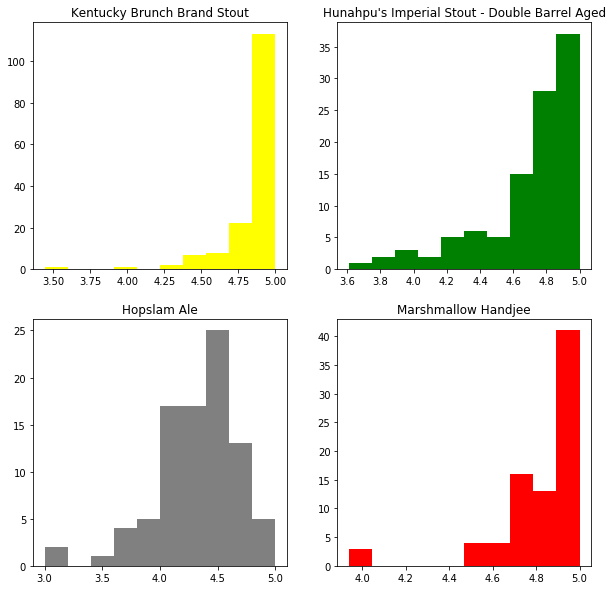

In [15]:
# Rating Distribution by random slected beer
fig, axs = plt.subplots(2,2, figsize=(10,10))
axs= axs.flatten()
axs[0].hist(nonzerp_np(new_rawData.iloc[0,:]), color = 'yellow')
axs[1].hist(nonzerp_np(new_rawData.iloc[20,:]), color = 'green')
axs[2].hist(nonzerp_np(new_rawData.iloc[40,:]), color = 'grey')
axs[3].hist(nonzerp_np(new_rawData.iloc[60,:]), color = 'red')

axs[0].set_title(new_rawData.index[0])
axs[1].set_title(new_rawData.index[20])
axs[2].set_title(new_rawData.index[40])
axs[3].set_title(new_rawData.index[60])

plt.savefig('system2.png', bbox_inches='tight')
plt.show()

__Majority of beers came from the United States. Others are Belgium Germany, and United Kingdom.__

In [16]:
set(overall_info['country'])

{'Australia',
 'Austria',
 'Belgium',
 'Brazil',
 'Canada',
 'China',
 'Czech Republic',
 'Denmark',
 'Finland',
 'France',
 'Germany',
 'Ireland',
 'Italy',
 'Jamaica',
 'Japan',
 'Laos',
 'Lithuania',
 'Louisiana',
 'Mexico',
 'Netherlands',
 'New York',
 'Norway',
 'Philippines',
 'Poland',
 'Russian Federation',
 'Spain',
 'Sri Lanka',
 'Switzerland',
 'Thailand',
 'Ukraine',
 'United Kingdom',
 'United States',
 'Viet Nam'}

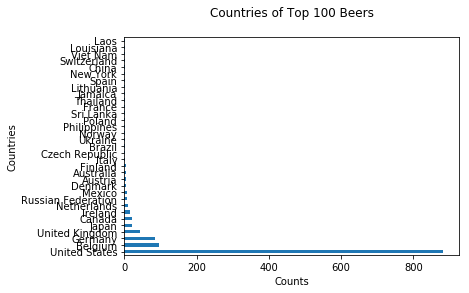

In [17]:
# Countries of Top 100 Beers
overall_info['country'].value_counts().plot(kind='barh')

plt.title('Countries of Top 100 Beers\n')
plt.xlabel('Counts')
plt.ylabel('Countries')
plt.savefig('system3.png', bbox_inches='tight')
plt.show()

__Most common beers are sold yearly, seasonally, and then sold in Winter.__

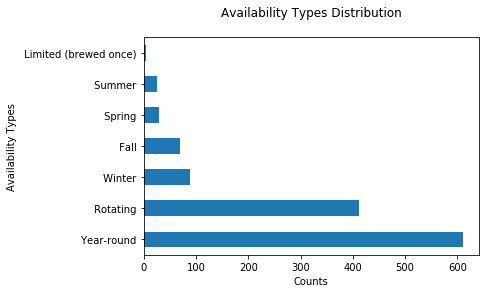

In [18]:
# Visualizing counts by availability type 
overall_info['availability'].value_counts().plot(kind='barh')

plt.title('Availability Types Distribution\n')
plt.xlabel('Counts')
plt.ylabel('Availability Types')
plt.savefig('system4.png', bbox_inches='tight')
plt.show()

# 2. Modeling

In general, there are two of the most popular way to approach recommendation:
- [**Collaborative Filtering**](https://blog.dominodatalab.com/recommender-systems-collaborative-filtering/): For each user, recommender systems recommend items based on how similar users liked the item. Let’s say Alice and Bob have similar interests in video games. Alice recently played and enjoyed the game Legend of Zelda: Breathe of the Wild. Bob has not played this game, but because the system has learned that Alice and Bob have similar tastes, it recommends this game to Bob. In addition to user similarity, recommender systems can also perform collaborative filtering using item similarity (“Users who liked this item also liked X”).
<br><br>
- [**Content-based Filtering**](https://blog.dominodatalab.com/recommender-systems-collaborative-filtering/): If companies have detailed metadata about each of your items, they can recommend items with similar metadata tags. For example, let’s say I watch the show Bojack Horseman on Netflix. This show may have metadata tags of “Animated”, “Comedy”, and “Adult”, so Netflix recommends other shows with these metadata tags, such as Family Guy.

In our project, we will focus on Collaborative Filtering algorithms becasue Content-based Filtering requires item metadata. However, the information data of beers has large sparsity, and even there are many beers do not among the list of infmation data. Therefore, Collaborative Filtering algorithms are more accessible. Since CF does not require the content of itmes and only the rating are sufficient, it is easy to implement the system and scales well with correlated items.

# 2.1 Memory-based(Heuristic) Collaborative Filtering
**Memory-based algorithmns** make predictions by operating on data (users, items, and ratings) and they can be classified into:**User-to-User Collaborative Filtering** and **Item-to-Item Collaborative Filtering**.

Before heading into algorithm, we wrote functions to evaluate our algorithmns and model:
- `delete_zero()` is used to delete all the zero value in the real rating data, and predicted rating of the same beer by the same user at the same time.

In [19]:
# deleting the 0 values in the data
def delete_zero(dat, pred):
    pred = pred[dat.nonzero()].flatten()
    dat = dat[dat.nonzero()].flatten()
#    list_1 = []
#    list_2 = []

#    for i in range(dat.shape[0]):
#        for j in range(dat.shape[1]):
#            if dat[i,j] != 0.0:
#                list_1.append(dat[i,j])
#                list_2.append(pred[i,j])
    return np.array(dat),np.array(pred)

`mae_rmse` returns `Mean Absolute Error` and `Root Mean Square Error`, which measure error between actural ratings vs. rating predicted by the system. The difference between RMSE and MAE is that:
- MAE gives equal weight to all individual differences in the average:
<br><br>
$$\large \frac{1}{n}\sqrt{\sum_{u,i}|p_{u,i} - r_{u,i}|} $$
- RMSE gives a relatively high weight to large errors:
<br><br>
$$\large \sqrt{\frac{1}{n}\sum_{u,i}(p_{u,i} - r_{u,i})^2}$$
    - n is the number of rating data
    - $p_{u,i}$ is the predicted rating of $u$-th users by the i-th
    - $r_{u,i}$ is the true rating of u-th users by the $i$-th

In [20]:
# calculate MSE and RMSE of mocels
def mae_rmse(ground_truth, prediction):
    mae = mean_absolute_error(prediction, ground_truth)
    rmse = sqrt(mean_squared_error(prediction, ground_truth))
    
    return mae, rmse

Another way to evaluate our systems is to visualize `roc curve` and `auc`. We give `high` or `low` labels to ratings by custmized thresholds and see how well recommends systems predict the label. At the end, we will plot their roc curve and calculate auc value.

In [21]:
# Add label
def add_label(data, thresholds = None):
    data = np.array(data).astype(str)
    for i in range(data.shape[0]):
        if data[i] >= thresholds:
            data[i] = 'high'
        else:
            data[i] = 'low'
            
    return(data)

In [22]:
def plot_roc_auc(true_lab, pred, col=None):
    
    # Calculate fpr, tpr, and auc
    fpr, tpr, thresholds = roc_curve(true_lab, pred, pos_label = 'high')
    auc_ = auc(fpr, tpr)
    
    # Plot roc curve
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, col, label = 'AUC = %0.2f' % auc_)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

## 2.1.1 User-to-User CF

[**User-to-User Collaborative Filtering**](https://www.analyticsvidhya.com/blog/2016/06/quick-guide-build-recommendation-engine-python/):  Here we find look alike customers (based on similarity) and offer products which first customer’s look alike has chosen in past. This algorithm is very effective but takes a lot of time and resources. It requires to compute every customer pair information which takes time. Therefore, for big base platforms, this algorithm is hard to implement without a very strong parallelizable system.

## Measuring Similarity

[**Measuring Similarity**](https://blog.dominodatalab.com/recommender-systems-collaborative-filtering/): When we compute similarity, we are going to calculate it as a measure of “anti-distance”. The higher the distance between two objects, the more “farther apart” they are. On the other hand, the higher the similarity between two objects, the more “closer together” they are. Usually similarity metrics return a value between 0 and 1, where 0 signifies no similarity (entirely dissimilar) and 1 signifies total similarity (they are exactly the same). Technically, there are many ways to calculate similarities: Euclidean Distance, Pearson Correlation,etc. We will use cosine similarity in both of User-to-User and Item-to-Item CF.

**Cosine Similarity**: it is the most commonly used measures of similarity. Finding the cosine similarity between two data objects requires that both objects represent their attributes in a vector. Similarity is then measured as the angle between the two vectors. 
<br><br>
$$\large cos(\theta) = \frac{A \cdot B}{||A||||B||}$$ <br>
A perfect correlation will have a score of 1 (or an angle of 0) and no correlation will have a score of 0 (or an angle of 90 degrees).

Since we are calculating user-to-user cosine similarities and the rows of `new_rawData` is beer class, we changed rows to user class by transposing `new_rawData` and then calculate cosine similarities. The metric below is the cosine similarities between 159 users. We can see the similarities on the diagnal are 1.00 as they are the same user. 

In [23]:
new_rawData_T = new_rawData.T
cosine_sim = 1-pairwise_distances(new_rawData_T, metric="cosine")
pd.DataFrame(cosine_sim).head()

,0,1,2,3,4,5,6,7,8,9,...,149,150,151,152,153,154,155,156,157,158
0,1.000000,0.537896,0.114253,0.185072,0.605874,0.176214,0.525800,0.208713,0.310875,0.146033,...,0.291680,0.329514,0.492622,0.525113,0.609058,0.474718,0.299193,0.171696,0.489982,0.136799
1,0.537896,1.000000,0.153032,0.170818,0.455301,0.243024,0.490277,0.264025,0.204986,0.224688,...,0.574977,0.444769,0.584738,0.554759,0.590637,0.529916,0.437227,0.168153,0.579755,0.088267
2,0.114253,0.153032,1.000000,0.179889,0.128106,0.137525,0.156140,0.143291,0.096687,0.069247,...,0.072642,0.049835,0.110573,0.082298,0.113104,0.083558,0.070539,0.070462,0.118227,0.123586
3,0.185072,0.170818,0.179889,1.000000,0.256825,0.100531,0.081392,0.200322,0.447156,0.216337,...,0.150089,0.239738,0.179258,0.192818,0.151997,0.211027,0.219845,0.000000,0.090875,0.000000
4,0.605874,0.455301,0.128106,0.256825,1.000000,0.219340,0.411796,0.236726,0.322890,0.189133,...,0.253481,0.304119,0.467959,0.462168,0.494785,0.465776,0.278833,0.146947,0.396031,0.120374


After getting the similarity matrix, we need to predict the rating scores. Predictions are computed as weighted average of deviations from neighbor’s mean and adding it to active user’s mean rating. Deviations are used to adjust for the user associated biases. User biases occur as certain users may tend to always give high or low ratings to all items. The equation we use to calculate is:
<br><br>
$$\large p_{a,i} = \bar{r_a} + \frac{\sum_{u\in K}(r_{u,i}-\bar{r_{u,i}\times w_{a,u}})}{\sum_{u\in K}w_{a,u}}$$
- $P(a,i)$: the prediction rating for user a to item $i$
- $\bar{r}_a$: the average rating of user $a$ to all items
- $r_{u,i}$: is the rating user $u$ gives to item $i$
- $\bar{r_u}$: is the average rating of user $u$ to all items
- $r_{u,i}-\bar{r_u}$: the difference between the rating of an user give item $i$ and this user's average rating on all items
- $w_{a,u}$: the similarity between user $a$ and user $u$

In [24]:
#calculate each user's average rating
mean_rating=new_rawData_T.mean(axis=1)

#the difference between the rating of an user give to each item and this user's average rating 
rating_diff=new_rawData_T.iloc[:,:].values-mean_rating[:, np.newaxis]

#how much each user's rating can influence the predictions on target user's rating
top=cosine_sim.dot(rating_diff)

#the sum of cosine similarities between the target user and other users
bottom=np.array([np.abs(cosine_sim).sum(axis=1)]).T

In [25]:
# Predict score using user-to-user cosine similarities
pred_user = mean_rating[:, np.newaxis] + top / bottom
pd.DataFrame(pred_user).head()

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
0,4.489515,1.424712,3.444746,2.087613,3.512252,3.212174,3.439498,3.192551,3.298408,3.224806,...,0.058422,0.130205,0.139066,0.152104,0.258113,0.247223,0.185528,-0.043417,0.157072,0.093875
1,5.274405,2.451446,4.233269,3.117390,4.312363,4.069273,4.184764,4.032432,4.097935,3.970438,...,0.917063,0.967140,1.028245,1.009007,1.174890,1.010959,1.045128,0.769487,1.015576,0.923694
2,3.540935,0.852234,1.987310,1.014415,2.044986,1.751809,2.009870,1.727681,2.078541,2.001653,...,-0.502225,-0.673538,-0.644292,-0.605465,-0.589488,-0.617125,-0.669783,-0.821545,-0.690097,-0.752319
3,3.899827,0.471106,3.015265,0.917007,2.872909,2.297834,2.573953,2.248414,2.156151,2.560093,...,-0.635669,-0.578978,-0.605347,-0.648216,-0.543019,-0.632174,-0.593145,-0.748542,-0.646242,-0.643363
4,4.075303,0.973355,3.055018,1.587336,3.082620,2.790122,2.989874,2.722689,2.844349,2.781473,...,-0.361517,-0.302981,-0.275043,-0.276138,-0.171978,-0.211469,-0.228534,-0.451476,-0.293545,-0.336345


The `pred_user` matrix gives the prediction of user scores of all users. According to these socres, we can use some users have many socres are lower than 1.0 or even negative scores. Because we have a large sparsity of data, there is a cold start problem. The disadvanatage of Memory-based algorithms is that is depends on human ratings, and therefore it cannot recommend for new users (aka cold start problem.) That is the reason we cannot have a good preiction for new users.

In the below, we calculate the MAE, RMSE, AUC, and plot roc curve for model evaluation.

In [26]:
# Keep the nonzero rating is both truth ground and predicted datasets
nonzero_user_dat, nonezero_user = delete_zero(new_rawData_T.values, pred_user)

In [27]:
# Calculate MAE and RMSE
mae_rmse(nonzero_user_dat, nonezero_user)

(2.122478217524963, 2.3532416145906407)

In [28]:
lab_user_rate = add_label(nonzero_user_dat, '3')
user_pred = nonezero_user.astype(int)

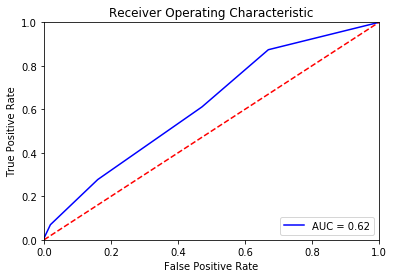

In [29]:
plot_roc_auc(lab_user_rate,user_pred, col= 'blue')

## 2.1.2 Item-to-Item CF

[**Item-to-Item Collaborative Filtering**](https://www.analyticsvidhya.com/blog/2016/06/quick-guide-build-recommendation-engine-python/):  It is quite similar to previous algorithm, but instead of finding customer look alike, we try finding item look alike. Once we have item look alike matrix, we can easily recommend alike items to customer who have purchased any item from the store. This algorithm is far less resource consuming than user-user collaborative filtering. Hence, for a new customer the algorithm takes far lesser time than user-user collaborate as we don’t need all similarity scores between customers. And with fixed number of products, product-product look alike matrix is fixed over time.

Similarily, we calculate the cosine similarity first. But we will calculate the similarity between beers:

In [30]:
true_rat = new_rawData.values
cosine_sim = 1-pairwise_distances(true_rat, metric="cosine")
pd.DataFrame(cosine_sim).head()

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
0,1.000000,0.671274,0.875994,0.723271,0.867604,0.858850,0.858313,0.848783,0.842334,0.845468,...,0.346584,0.348215,0.330186,0.348103,0.348929,0.350635,0.351970,0.291465,0.346353,0.335686
1,0.671274,1.000000,0.572794,0.652670,0.575884,0.598761,0.570187,0.604716,0.582923,0.554882,...,0.342241,0.393558,0.374762,0.358604,0.345608,0.327949,0.388513,0.415616,0.422655,0.390871
2,0.875994,0.572794,1.000000,0.719892,0.903531,0.890338,0.857943,0.886800,0.751093,0.771671,...,0.217481,0.276886,0.300232,0.255303,0.294143,0.230810,0.341771,0.189379,0.318844,0.307022
3,0.723271,0.652670,0.719892,1.000000,0.721027,0.726554,0.677637,0.726151,0.663821,0.643420,...,0.293228,0.313737,0.287205,0.324083,0.429901,0.208769,0.431354,0.233968,0.466181,0.351963
4,0.867604,0.575884,0.903531,0.721027,1.000000,0.897829,0.879509,0.889992,0.789133,0.808614,...,0.234976,0.325808,0.312133,0.260180,0.331123,0.289214,0.365753,0.235846,0.358179,0.316326


The rating for target item i for active user a can be predicted by using a simple weighted average as:
<br><br>
$$\large p_{a,i} = \frac{\sum_{j \in k}r_{a,j}w_{i,j}}{\sum_{j \in K}|w_{i,j}|}$$

- $K$ all 600 items rated by active user a, 
- $w_{i,j}$ is the similarity between items i and j.


In [31]:
# Predict score using item-to-item cosine similarities
pred_item = cosine_sim.dot(true_rat)/np.array([abs(cosine_sim).sum(axis=0)]).T
pd.DataFrame(pred_item)

,0,1,2,3,4,5,6,7,8,9,...,149,150,151,152,153,154,155,156,157,158
0,1.419859,2.309058,0.153667,0.086188,0.849639,0.558852,1.957063,0.532820,0.273580,0.155614,...,2.000713,0.935977,1.684236,1.480000,1.952885,1.250067,0.938136,0.313319,2.433297,0.239830
1,1.161997,2.161240,0.148066,0.068088,0.691759,0.589344,1.862274,0.565058,0.207067,0.145434,...,2.048214,0.817140,1.554674,1.288279,1.657890,1.116397,0.843384,0.288485,2.276096,0.245491
2,1.467455,2.401168,0.140114,0.093919,0.884165,0.569674,1.972940,0.530266,0.296208,0.172961,...,2.053895,1.000284,1.772970,1.560416,2.032562,1.323102,1.002752,0.285980,2.446052,0.209215
3,1.301556,2.301175,0.138045,0.071446,0.764794,0.553463,1.885047,0.500943,0.232901,0.155133,...,2.046196,0.888682,1.638369,1.416739,1.885276,1.203596,0.908607,0.298077,2.414122,0.221308
4,1.455499,2.377986,0.141333,0.089311,0.869649,0.544466,1.989984,0.521187,0.285072,0.160354,...,2.009731,0.979533,1.742792,1.540038,2.018617,1.296438,0.985679,0.293234,2.448086,0.214209
5,1.452475,2.403929,0.139973,0.088827,0.873294,0.560987,1.972200,0.549831,0.283874,0.168490,...,2.066893,0.991429,1.764376,1.545773,2.017676,1.318444,1.000903,0.289964,2.425108,0.208378
6,1.464327,2.360843,0.144332,0.085912,0.869628,0.536035,1.965198,0.506532,0.282194,0.153043,...,1.993098,0.958249,1.723996,1.538282,2.013155,1.277690,0.956910,0.306254,2.480668,0.220872
7,1.444466,2.377263,0.137845,0.086622,0.857641,0.553617,1.995098,0.542727,0.280568,0.165857,...,2.046797,0.982533,1.751943,1.536338,2.009393,1.303474,0.988730,0.286771,2.417561,0.217144
8,1.430764,2.321572,0.148831,0.079391,0.850657,0.526886,1.959125,0.514482,0.271213,0.144343,...,1.985080,0.938552,1.674123,1.489264,1.982624,1.237863,0.934758,0.327076,2.492557,0.233287
9,1.464353,2.335122,0.149615,0.087396,0.867139,0.528917,1.949706,0.514296,0.286384,0.149443,...,1.971807,0.950887,1.697642,1.518318,2.017904,1.264107,0.934240,0.322469,2.511390,0.231008


As we can see, the prediction are generally really low here. After doing research, we found Item-to-Item CF works efficiently when users are more than beers since we can use more data to calculate the similarities. With less complete data and ratings from different users, Item-to-Item CF is likely as not good as User-to-User CF

In [32]:
nonzero_item_dat, nonezero_item = delete_zero(true_rat, pred_item)

In [33]:
mae_rmse(nonzero_item_dat, nonezero_item)

(2.3348905514121268, 2.5067870218247394)

In [34]:
lab_item_rate = add_label(nonzero_item_dat, '3')
item_pred = nonezero_item.astype(int)

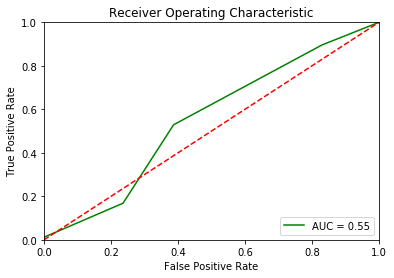

In [35]:
plot_roc_auc(lab_item_rate,item_pred, col= 'green')

According to the data above,although the item-based CF has similar MAE and RMSE to User-based CF, it accuracy is not good enough. Even at some points, TPR is lower than FPR.

# 2.2 Model-based Collaborative Filtering
In this approach, models are developed using different data mining, machine learning algorithms to predict users' rating of unrated items. There are many model-based CF algorithms. Bayesian networks, clustering models, latent semantic models such as singular value decomposition, probabilistic latent semantic analysis, multiple multiplicative factor, latent Dirichlet allocation and Markov decision process based models. And we will use Non-negative Matrix Factorization.

Having a non-negative data matrix containing a set of items with a fixed number of features, NMF algorithm will produce a factorization of the data matrix and reveal the interesting **latent factors** underlying the interactions between items and their features. We can consider that each item can be described using these **latent factors**, and, using the information about how much each of **latent factors** is expressed for each item, we can cluster the items that share the same **latent features**. 
![NMF](http://vazic.me/wp-content/uploads/2015/08/NMF.png)
<br><br>
According to the picture above the **rows** of **W** is our **user class** and the **columns** of **W** represents the **latent factors** of different **users**. The **columns** of the **H** is our **beer class** and the **rows** of **H** is the **latent factors** for different beers. These two kinds of latent factors are believed to be responsible for the observed data in **V**.The building blocks are not individual factors but weighted bundles of factors that serve a common purpose.
<br><br>
The reason why it’s called non-negative matrix factorization is that it returns factors and weights with **no negative values**. This means that all the features in the data matrix must have positive values. This also prevents latent factors taking away pieces of other latent factors as NMF will not find results that explicitly exclude certain factors from the original data matrix.

## 2.2.1 [Non-negative Matrix Factorization](http://vazic.me/non-negative-matrix-factorization-nmf/)

In the following, we use 5-fold cv to cross validate NMF model with 5, 16, 27, 38, 50, 61, 72, 83, 95 numbers of components(aka latent factors) to find the best fold and numbers of components. We plot the roc curves of each combination of NMF and plot the mean roc curve and its confidence interval.

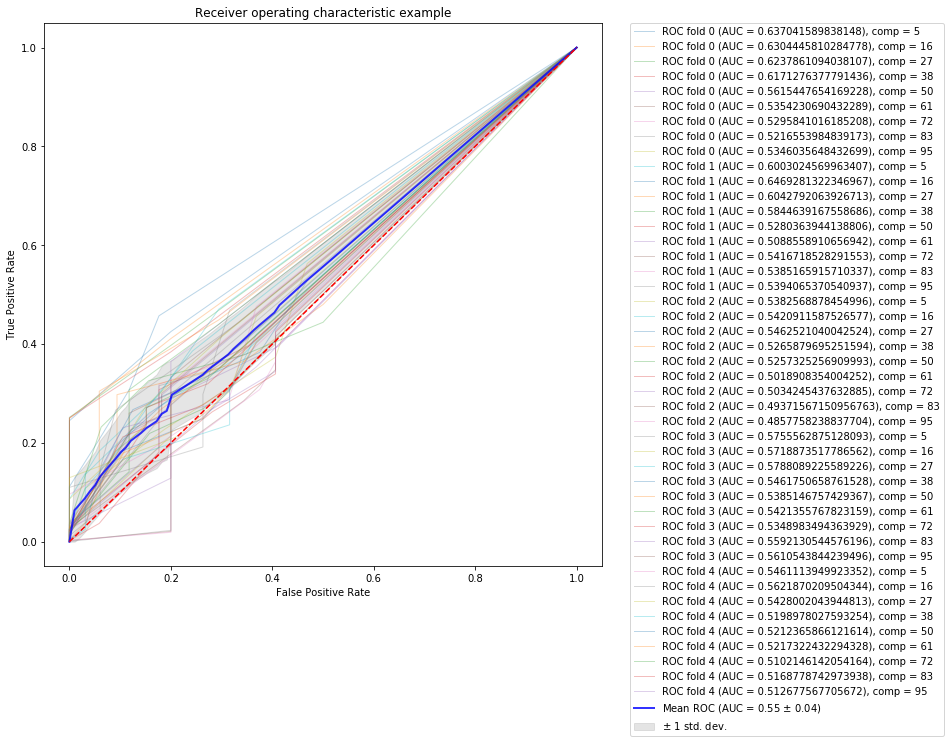

In [36]:
kf = RepeatedKFold(n_splits=5, n_repeats=1, random_state=123) 

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
plt.figure(figsize=(10,10))
for train_index, test_index in kf.split(new_rawData.T):
    train, test = new_rawData.T.ix[train_index], new_rawData.T.ix[test_index]
    
    #fit the nmf model with different component combinations
    components = np.linspace(5, 95, num=9).astype(int)
    
    for comp in list(components):
        model = skld.NMF(n_components=comp, init='nndsvda', max_iter=500, random_state=0)
        W = model.fit_transform(train)
        H = model.components_
        pred_rat = W.dot(H)
        
        nmf_test, nmf_pred = delete_zero(test.values, pred_rat)
        lab_rat = add_label(nmf_test, '3')
        nmf_pred = nmf_pred.astype(int)

        fpr, tpr, thresholds = roc_curve(lab_rat, nmf_pred, pos_label = 'high')
        auc_ = auc(fpr, tpr)
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        aucs.append(auc_)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold {0} (AUC = {1}), comp = {2}'.format(i, auc_, comp))
    
    i += 1

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

As we can see, the mean AUC is 0.55 $\pm$ 0.04, which is similar to item-to-item CF. But we find `fold0` have a better performance in general. Therefore we use `fold0` to do the training.

In [37]:
# Find the index of first fold
train_ix, test_ix = list(kf.split(new_rawData.T))[0]

In [38]:
train_ix

array([  0,   1,   2,   3,   4,   5,   6,   7,   9,  10,  11,  12,  14,
        15,  16,  17,  18,  19,  21,  22,  25,  26,  27,  29,  30,  32,
        34,  35,  38,  39,  40,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  54,  55,  56,  57,  58,  59,  63,  64,  66,  67,  68,
        69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  80,  82,  83,
        84,  85,  87,  88,  91,  92,  93,  94,  95,  96,  97,  98,  99,
       100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 111, 112, 113,
       115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 128,
       129, 130, 131, 132, 134, 135, 137, 138, 140, 141, 142, 143, 146,
       147, 149, 150, 151, 152, 153, 154, 156, 157, 158])

Althought we know the best fold is `fold0`, the best number of latent factors is still unknown. Therefore, we use `nmf_run_rid` to get the data of mae, rmse and auc with different number of `n_components`

In [39]:
def nmf_run_grid(dat, testset, comp): 
    data = [] 
    for i in list(comp):
        model = skld.NMF(n_components=i, init='nndsvda', max_iter=500, random_state=0)
        W = model.fit_transform(dat)
        H = model.components_
        pred_rat = W.dot(H)
        
        nmf_test, nmf_pred = delete_zero(testset.values, pred_rat)
        mae, rmse = mae_rmse(nmf_test, nmf_pred)
        
        lab_rat = add_label(nmf_test, '3')
        nmf_pred = nmf_pred.astype(int)

        fpr, tpr, thresholds = roc_curve(lab_rat, nmf_pred, pos_label = 'high')
        auc_ = auc(fpr, tpr)
        
        data.append([i, mae, rmse, auc_])
    return data

In [40]:
components = np.linspace(5, 95, num=9).astype(int)
train, test = new_rawData.T.ix[train_ix], new_rawData.T.ix[test_ix]

In [41]:
data = pd.DataFrame(nmf_run_grid(train,test,components))

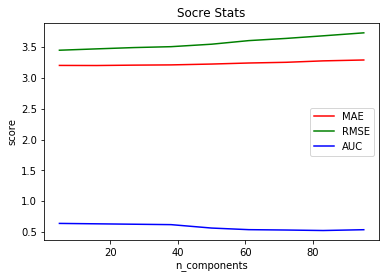

In [42]:
plt.figure(0).clf()
plt.plot(data.iloc[:,0],data.iloc[:,1], 'red', label = 'MAE')
plt.plot(data.iloc[:,0],data.iloc[:,2], 'green', label = 'RMSE')
plt.plot(data.iloc[:,0],data.iloc[:,3], 'Blue', label = 'AUC')
plt.title('Socre Stats')
plt.xlabel('n_components')
plt.ylabel('score')
plt.legend(loc=0)

According to the plot, MAE and RMSE rise as we add more latent factors and AUC decreases. Therefore, we decide to use 5 latent factors. We fit NMF with 5 latent factors and plot its roc curve.

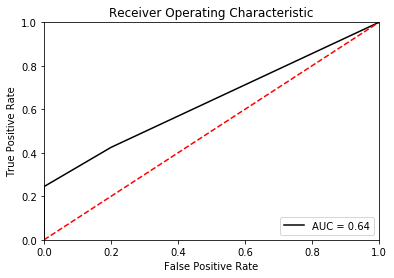

In [43]:
model = skld.NMF(n_components=5, init='nndsvda', max_iter=500, random_state=0)
W = model.fit_transform(train)
H = model.components_
pred_rat = W.dot(H)
        
nmf_test, nmf_pred = delete_zero(test.values, pred_rat)     
lab_rat_nmf = add_label(nmf_test, '3')
nmf_pred = nmf_pred.astype(int)

plot_roc_auc(lab_rat_nmf,nmf_pred,col='black')

# 3. Model Evaluation and Model Selection

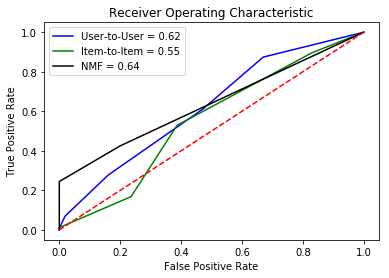

In [44]:
# Compare models using ROC Curve and AUC

plt.figure(0).clf()

# Item-to-Item roc
fpr, tpr, thresholds = roc_curve(lab_user_rate,user_pred, pos_label = 'high')
auc_ = auc(fpr, tpr)
plt.plot(fpr, tpr,'blue', label = 'User-to-User = %0.2f' % auc_)

# User-to-User roc
fpr, tpr, thresholds = roc_curve(lab_item_rate,item_pred, pos_label = 'high')
auc_ = auc(fpr, tpr)
plt.plot(fpr, tpr,'green', label = 'Item-to-Item = %0.2f' % auc_)

# NMF roc
fpr, tpr, thresholds = roc_curve(lab_rat_nmf,nmf_pred, pos_label = 'high')
auc_ = auc(fpr, tpr)
plt.plot(fpr, tpr,'black', label = 'NMF = %0.2f' % auc_)

plt.plot([0, 1], [0, 1],'r--')
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=0)

ROC curve shows Item-to-Item CF has the worse performance, and NMF model has the highes auc values. 

In [45]:
# Compare models use mse and rmse
print(mae_rmse(nonzero_user_dat, nonezero_user))
print(mae_rmse(nonzero_item_dat, nonezero_item))
print(mae_rmse(nmf_test, nmf_pred))

(2.122478217524963, 2.3532416145906407)
(2.3348905514121268, 2.5067870218247394)
(3.56638354482194, 3.7800127483124752)


Although NMF model have the best auc values, its MAE and RMSE is higher than other two methods. Therefore, we will build our Recommender System based on user-based CF since it has a relatively high auc with the smallest MAE and RMSE. 

# 4. Recommender System

In [46]:
# Use User-to-User CF to build Recommender System
def recommendation(user_name,data):
    
    # Cosine similarity
    data_T = data.T
    cosine_sim = 1-pairwise_distances(data_T, metric="cosine")
    
    # Prediction
    mean_rating=data_T.mean(axis=1)
    rating_diff=data_T.iloc[:,:].values-mean_rating[:, np.newaxis]
    top=cosine_sim.dot(rating_diff)
    bottom=np.array([np.abs(cosine_sim).sum(axis=1)]).T
    pred_user = mean_rating[:, np.newaxis] + top / bottom    
    pred_user = pd.DataFrame(pred_user, index = data_T.index, columns = data_T.columns)
    
    # Set the rated data to 0.0, so that we won't recommend it again
    for i in range(pred_user.shape[0]):
        for j in range(pred_user.shape[1]):
            if data_T.iloc[i,j] != 0.0:
                pred_user.iloc[i,j] = 0.0
                
    recomm_list = list(pred_user.loc[user_name].sort_values(ascending=False).head(10).index)          
    print('For our user {0}, we recommend: {1}'.format(user_name, recomm_list))

In [47]:
recommendation('Jimmeekrek', new_rawData)

For our user Jimmeekrek, we recommend: ['Dinner', 'Atrial Rubicite', 'Duck Duck Gooze', 'Very Green', 'Abner', 'Swish', 'Very Hazy', 'Beatification', 'Heavy Mettle', 'King Julius']


Through this project, we learn how to using custimized API to extract data from website. In the meantime, we have more understanding about the recommendation system. In the future, we will need work hard on the API so that we can keep update the data to refine our algorithms (Collaborative Fitlering Algorithm works efficiently when we keep updating the data). Also, we can extract more complete information so that we can work on content-based model.